In [49]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import yaml
import jax
import jax.numpy as jnp
import copy
# from functools import partial

In [50]:
# Constants
MU = 3.986004418 * 10**5 # km^3/s^2
R_EARTH = 6378
R_SAT = 550 + R_EARTH


In [51]:
class landmark: # Class for the landmark object. Coordinates in ECEF (TODO: Check with Paulo or Zac if this is correct)
    def __init__(self, x: float, y: float, z: float, name: str) -> None:
        self.pos = np.array([x,y,z])
        self.name = name


In [52]:
class satellite:

    def __init__(self, state: np.ndarray, pos_cov_init: float, vel_cov_init: float, robot_id: int, dim: int, meas_dim: int, R_weight: float, N: int, n_sats: int, landmarks: object) -> None:
        self.x_0 = state
        self.cov_m = np.diag(np.array([float(pos_cov_init), float(pos_cov_init), float(pos_cov_init), float(vel_cov_init), float(vel_cov_init), float(vel_cov_init)]))
        self.id = robot_id # Unique identifier for the satellite
        self.dim = dim # State dimension of the satellite (currently 3 position + 3 velocity)
        self.meas_dim = meas_dim
        self.R_weight = R_weight # This is the variance weight for the measurement noise
        self.N = N # Number of time steps
        self.n_sats = n_sats # Number of satellites
        self.landmarks = landmarks
        # self.inv_cov = jnp.linalg.inv(self.cov_m)
        
        # self.info_matrix = np.linalg.inv(self.cov_m)
        # self.info_vector = self.info_matrix@self.x_0
        # TODO: Adjust initial x_m with random error direction for both position and velocity (different scales)
        self.x_m = self.x_0 # + np.array([1,0,0,0,0,0]) # Initialize the measurement vector exactly the same as the initial state vector
        self.x_p = self.x_m # Initialize the prior vector exactly the same as the measurement vector
        self.cov_p = self.cov_m # Initialize the prior covariance exactly the same as the measurement covariance

        self.min_landmark_list = None # Initialize an array of the closest landmark to the satellite t
        self.curr_pos = self.x_0[0:3] #Determines the current position of the satellite (Necessary for landmark bearing and satellite ranging)
        self.other_sats_pos = np.zeros((N, 3, int(n_sats-1))) # Provides the position of the other satellites for all N timesteps
        # self.sats_visible = np.zeros((N,n_sats-1)) # Determines whether the other satellites are visible to this satellite


    def h_landmark(self, x):
        min_landmark = closest_landmark(x, self.landmarks)
        norm = jnp.sqrt((x[0] - min_landmark[0])**2 + (x[1] - min_landmark[1])**2 + (x[2] - min_landmark[2])**2)
        
        return (x[0:3] - min_landmark)/norm

    def H_landmark(self, x):
        # Use jax to autodifferentiate
        jac = jax.jacobian(self.h_landmark)(x)
        # min_landmark = closest_landmark(x, self.landmarks)
        # norm = jnp.sqrt((x[0] - min_landmark[0])**2 + (x[1] - min_landmark[1])**2 + (x[2] - min_landmark[2])**2)
        # jac = jnp.eye(3)/norm - np.outer(x - min_landmark, x - min_landmark)/(norm**3)
        return jac

    def h_inter_range(self, i, j, x): # This function calculates the range measurement between the satellite and another satellite
        sat_id = j-3 # j is the range measurement index starting from 3
        sat_pos = self.other_sats_pos[i,:,sat_id]
        if self.is_visible(sat_pos):
            return jnp.linalg.norm(x[0:3] - sat_pos) 
        else:
            return jnp.linalg.norm(0)

    def H_inter_range(self, i, j, x):
        # vec = [i,j,x]
        jac = jax.jacobian(self.h_inter_range, argnums=2)(i, j, x)
        return jac

    def measure_z_range(self, index: int, sats: list) -> np.ndarray:
        z = np.empty((0))
        for sat in sats:
            if sat.id != self.id:

                if self.is_visible(sat.curr_pos): # If the earth is not in the way, we can measure the range
                    noise = np.random.normal(loc=0,scale=math.sqrt(self.R_weight),size=(1))
                    d = np.array([np.linalg.norm(self.curr_pos - sat.curr_pos)]) + noise
                    z = np.append(z,d,axis=0)
                    # self.sats_visible[index,sat.id] = 1

                else: # If the earth is in the way , we set the value to nan so it does not feature in the objective function
                   
                    z = np.append(z,np.array([0]),axis=0)
        return z
    
    def measure_z_landmark(self, landmarks: list) -> np.ndarray:
        # Determine the closest landmark to the satellite at the current state and calculate the bearing to that landmark
        if self.min_landmark_list is None:
            self.min_landmark_list = np.array([closest_landmark(self.curr_pos, landmarks)]).reshape(1,3)
        else:
            self.min_landmark_list = np.append(self.min_landmark_list,[closest_landmark(self.curr_pos, landmarks)],axis=0)
        
        noise = np.random.normal(loc=0,scale=math.sqrt(self.R_weight),size=(int(self.dim/2)))
        vec = (self.curr_pos  - self.min_landmark_list[-1]) + noise
        return vec/np.linalg.norm(vec)


    def is_visible(self, sat_pos) -> bool:
        # Check if the earth is in the way of the two satellites
        threshold_angle = math.atan(R_EARTH/R_SAT) # Note this is an approximation based on the assumption of a CIRCULAR orbit and earth
        # Calculate the angle between the two satellites
        vec = sat_pos - self.curr_pos
        vec_earth = np.array([0,0,0]) - self.curr_pos
        # Calculate the angle between the two vectors
        angle = math.acos(np.dot(vec,vec_earth)/(np.linalg.norm(vec)*np.linalg.norm(vec_earth)))
        if abs(angle) < threshold_angle:
            return False
        
        return True
    

In [53]:
def closest_landmark(pos, landmarks: list) -> object:
    """
    Find the closest landmark position to the current position.

    Args:
        pos (np.ndarray): The current position of the satellite.
        landmarks (list): A list of landmark objects, each having a 'pos' attribute.

    Returns:
        The position of the landmark object that is closest to the current position. 
        If no landmarks are provided, returns None.
    """
    min_dist = np.inf
    closest_landmark = None

    for landmark in landmarks:
        dist = jnp.linalg.norm(pos[0:3] - landmark.pos)
        if dist < min_dist:
            min_dist = dist
            closest_landmark = landmark

    # print(f"Closest landmark to satellite at position {pos} is {closest_landmark.name} at position {closest_landmark.pos}")
    if closest_landmark is None:
        return np.array([0,0,0])
    return closest_landmark.pos


def latlon2ecef(landmarks: list) -> np.ndarray:
    """
    Convert latitude, longitude, and altitude coordinates to Earth-Centered, Earth-Fixed (ECEF) coordinates.

    Args:
        landmarks (list of tuples): A list of tuples where each tuple contains:
            - landmark[0] (any): An identifier for the landmark.
            - landmark[1] (float): Latitude in radians.
            - landmark[2] (float): Longitude in radians.
            - landmark[3] (float): Altitude in kilometers.
    Returns:
        numpy.ndarray: A 2D array where each row corresponds to a landmark and contains:
            - landmark[0] (any): The identifier for the landmark.
            - X (float): The ECEF X coordinate in kilometers.
            - Y (float): The ECEF Y coordinate in kilometers.
            - Z (float): The ECEF Z coordinate in kilometers.
    """
    ecef = np.array([])
    a = 6378.137
    b = 6356.7523
    e = 1 - (b**2/a**2)
    
    # helper function
    def N(a,b,lat):
        return a**2/np.sqrt(a**2*np.cos(lat)**2 + b**2*np.sin(lat)**2)
    
    for landmark in landmarks:
        X = (N(a,b,float(landmark[1])) + float(landmark[3]))*np.cos(float(landmark[1]))*np.cos(float(landmark[2]))
        Y = (N(a,b,float(landmark[1])) + float(landmark[3]))*np.cos(float(landmark[1]))*np.sin(float(landmark[2]))
        Z = (N(a,b,float(landmark[1]))*(1-e) + float(landmark[3]))*np.sin(float(landmark[1]))
        ecef = np.append(ecef, np.array([landmark[0],X,Y,Z]), axis=0)
    
    return ecef.reshape(-1,4)


def state_transition(x):
    I = np.eye(3)
    A21 = -MU/(np.linalg.norm(x[0:3])**3)*I + 3*MU*np.outer(x[0:3],x[0:3])/(np.linalg.norm(x[0:3])**5)
    A = np.block([[np.zeros((3,3)), I], [A21, np.zeros((3,3))]])
    return A

In [54]:
def rk4_discretization(x, dt: float):
    r = x[0:3]
    v = x[3:6]

    def dr_dt(v):
        """Derivative of r with respect to time is velocity v."""
        return v

    def dv_dt(r):
        """Derivative of v with respect to time is gravitational acceleration."""
        return (-MU / (jnp.linalg.norm(r)**3)) * r

    # Calculate k1 for r and v
    k1_r = dr_dt(v)
    k1_v = dv_dt(r)

    # Calculate k2 for r and v
    k2_r = dr_dt(v + 0.5 * dt * k1_v)
    k2_v = dv_dt(r + 0.5 * dt * k1_r)

    # Calculate k3 for r and v
    k3_r = dr_dt(v + 0.5 * dt * k2_v)
    k3_v = dv_dt(r + 0.5 * dt * k2_r)

    # Calculate k4 for r and v
    k4_r = dr_dt(v + dt * k3_v)
    k4_v = dv_dt(r + dt * k3_r)

    # Combine the k terms to get the next position and velocity
    r_new = r + (dt / 6) * (k1_r + 2 * k2_r + 2 * k3_r + k4_r)
    v_new = v + (dt / 6) * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)

    # Return the updated state vector
    return jnp.concatenate((r_new, v_new))


# Numerical solution of the dynamics using Euler's method
def euler_discretization(x: np.ndarray, dt: float) -> np.ndarray:
    r = x[0:3]
    v = x[3:6]
    r_new = r + v*dt
    v_new = v + (-MU/(np.linalg.norm(r)**3))*r*dt
    return np.concatenate((r_new, v_new))

In [ ]:
#General Parameters
N = 1500
f = 1/60 #Hz
dt = 1/f
n_sats = 2
R_weight = 10e-2
bearing_dim = 3
state_dim = 6
meas_dim = n_sats-1 + bearing_dim
R = np.eye(meas_dim)*R_weight
# Process noise covariance matrix based on paper "Autonomous orbit determination and observability analysis for formation satellites" by OU Yangwei, ZHANG Hongbo, XING Jianjun
# page 6
Q = np.diag(np.array([10e-6,10e-6,10e-6,10e-12,10e-12,10e-12]))

#MC Parameters
num_trials = 5
nls_estimates = np.zeros((num_trials, state_dim * N))

In [56]:
### Landmark Initialization ###
# Import csv data for the lanldmarks
landmarks = []
with open('landmark_coordinates.csv', newline='',) as csvfile:
    reader = csv.reader(csvfile, delimiter=',',)
    for row in reader:
        landmarks.append(np.array([row[0],row[1], row[2], row[3]]))


landmarks_ecef = latlon2ecef(landmarks)
landmark_objects = []

# Initialize the landmark objects with their correct name and the ECEF coordinates
for landmark_obj in landmarks_ecef:
    landmark_objects.append(landmark(x=float(landmark_obj[1]), y=float(landmark_obj[2]), z=float(landmark_obj[3]), name=(landmark_obj[0])))


In [57]:
### Satellite Initialization ###
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

sats = []

for sat_config in config["satellites"]:
    sat_config["state"] = np.array(sat_config["state"])
    # sat_config["state"][5] = float(np.sqrt(MU/R_SAT)) # for now assign velocity using vis-viva equation
    sat_config["N"] = N
    sat_config["landmarks"] = landmark_objects
    sat_config["meas_dim"] = meas_dim
    sat_config["n_sats"] = n_sats
    sat_config["R_weight"] = R_weight
    satellite_inst = satellite(**sat_config)
    sats.append(satellite_inst)

In [58]:
# Generate synthetic data
x_traj = np.zeros((N, state_dim, n_sats)) # Discretized trajectory of satellite states over time period
# This loop is deterministic as we are always doing the same discretization so we do not need to regenerate the trajectories.
for sat in sats: 
    x = sat.x_0
    for i in range(N):
        x_traj[i,:,sat.id] = x
        x = rk4_discretization(x, dt)

# Get the positions of the other satellites for each satellite at all N timesteps
for sat in sats:
        sat_i = 0 #iterator variable
        for other_sat in sats:
            if sat.id != other_sat.id:
                sat.other_sats_pos[:,:,sat_i] = x_traj[:,0:3,other_sat.id] # Transfer all N 3D positions of the other satellites from x_traj
                sat_i += 1


In [59]:
## Calculate FIM directly in recursive fashion.
fim = np.zeros((num_trials,N*state_dim, N*state_dim))
f_prior = np.zeros((state_dim, state_dim))
f_post = np.zeros((state_dim, state_dim))

J = np.zeros((meas_dim, state_dim))
R_inv = np.linalg.inv(R)

cov_hist = np.zeros((N,n_sats,state_dim,state_dim))
sats_copy = copy.deepcopy(sats)

filter_position = np.zeros((num_trials, N, 3, n_sats))


for trial in range(num_trials):
    print("Monte Carlo Trial: ", trial)

    y_m = jnp.zeros((N,meas_dim,n_sats))
    H = np.zeros((meas_dim,state_dim))
    h = np.zeros((meas_dim))

    for i in range(N):

        for sat in sats_copy:
            if i < N-1:
                sat.curr_pos = x_traj[i+1,0:3,sat.id] #Provide the underlying groundtruth position to the satellite for bearing and ranging measurements
            A = state_transition(sat.x_m)
            sat.x_p = rk4_discretization(sat.x_m, dt)
            sat.cov_p = A@sat.cov_m@A.T + Q # Update the covariance matrix as a P_p = A*P*A^T + LQL^T


        for sat in sats_copy:
            H[0:bearing_dim,0:state_dim] = sat.H_landmark(sat.x_p)
            for j in range(3,meas_dim):
                H[j,0:state_dim] = sat.H_inter_range(i, j, sat.x_p)

            K = sat.cov_p@H.T@np.linalg.pinv(H@sat.cov_p@H.T + R)

            y_m = y_m.at[i,0:bearing_dim,sat.id].set(sat.measure_z_landmark(tuple(landmark_objects))) # This sets the bearing measurement
            y_m = y_m.at[i,bearing_dim:meas_dim,sat.id].set(sat.measure_z_range(i, sats_copy)) # This sets the range measurement

            h[0:bearing_dim] = sat.h_landmark(sat.x_p[0:3])
            for j in range(3,meas_dim):
                h[j] = sat.h_inter_range(i, j, sat.x_p[0:3])
            
            sat.x_m = sat.x_p + K@(y_m[i,:,sat.id] - h)
            sat.cov_m = (np.eye(state_dim) - K@H)@sat.cov_p@((np.eye(state_dim) - K@H).T) + K@R@K.T

            cov_hist[i,sat.id,:,:] += sat.cov_m

            filter_position[trial,i,:,sat.id] = sat.x_m[0:3]


        #Assume no knowledge at initial state so we don't place any information in the first state_dim x state_dim block
        if i > 0:
            start_i = i * state_dim
            A = state_transition(sats_copy[0].x_m)
            f_prior = A@f_post@A.T + np.linalg.inv(Q) # with process noise
            J[0:bearing_dim,0:3] = sats_copy[0].H_landmark(sats_copy[0].x_m[0:3])
            for j in range(3,meas_dim): ## Consider checks for nan values
                J[j,0:3] = sats_copy[0].H_inter_range(i, j, sats_copy[0].x_m[0:3])
            f_post = f_prior + J.T@R_inv@J
            fim[trial, start_i:start_i+state_dim,start_i:start_i+state_dim] = f_post

            # print(f"Satellite {sat.id} at time {i} has covariance {sat.cov_m}")
    
    sats_copy = copy.deepcopy(sats) # Reset the satellites for the next trial

# Average FIM
fim = np.mean(fim, axis=0)

#Get the average covariance matrix for each satellite for each timestep
for i in range(N):
    for sat in sats:
        cov_hist[i,sat.id,:,:] = cov_hist[i,sat.id,:,:]/num_trials

sat1_cov_hist = cov_hist[:,0,:,:]

# The FIM should be the inverse of the Cramer-Rao Bound. Isolating first step as it is full of 0 values and nor invertible.
# fim_acc = fim[state_dim:,state_dim:]
# crb = np.linalg.inv(fim_acc)
# crb_final = np.zeros((N*state_dim,N*state_dim))
# crb_final[state_dim:,state_dim:] = crb

# Using pseudo-inverse to invert the matrix
crb = np.linalg.pinv(fim)

# Plot the covariance matrix and the FIM diagonal entries.

crb_diag = np.diag(crb)


Monte Carlo Trial:  0
Monte Carlo Trial:  1
Monte Carlo Trial:  2
Monte Carlo Trial:  3
Monte Carlo Trial:  4


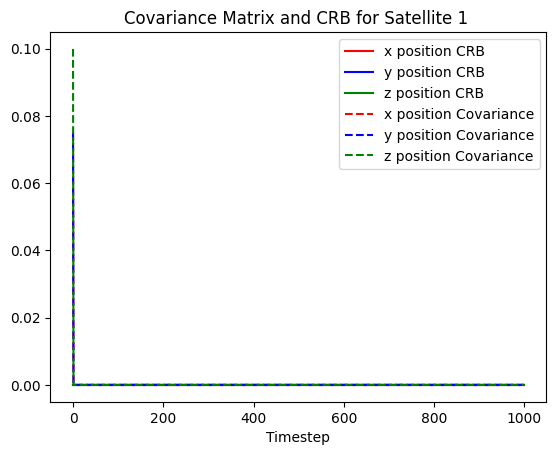

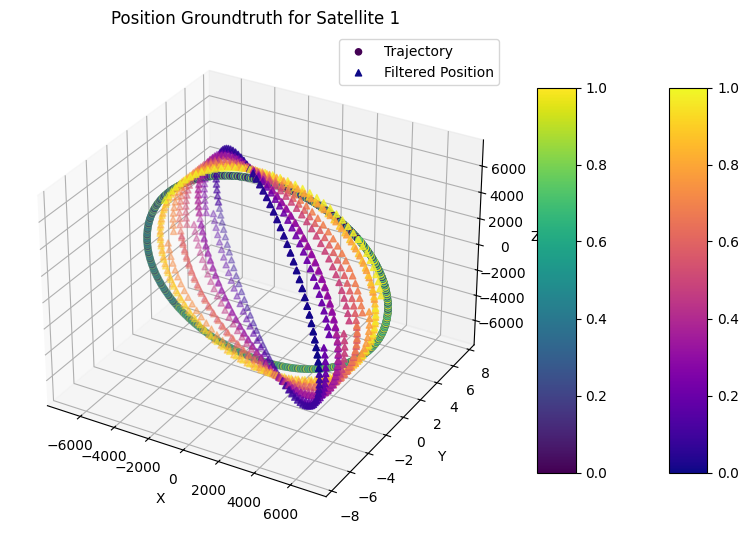

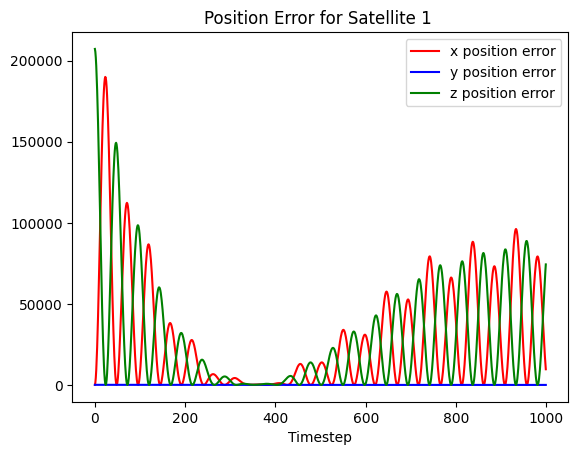

In [60]:
# Plot the covariance matrix and the FIM diagonal entries.
plt.figure()
plt.plot(crb_diag[0::state_dim], label='x position CRB', color='red')
plt.plot(crb_diag[1::state_dim], label='y position CRB', color='blue')
plt.plot(crb_diag[2::state_dim], label='z position CRB', color='green')
# plt.plot(crb_diag[3::state_dim], label='x velocity CRB', color='red')
# plt.plot(crb_diag[4::state_dim], label='y velocity CRB', color='blue')
# plt.plot(crb_diag[5::state_dim], label='z velocity CRB', color='green')
plt.plot(sat1_cov_hist[:,0,0], label='x position Covariance', color='red', linestyle='--')
plt.plot(sat1_cov_hist[:,1,1], label='y position Covariance', color='blue', linestyle='--')
plt.plot(sat1_cov_hist[:,2,2], label='z position Covariance', color='green', linestyle='--')
# plt.plot(sat1_cov_hist[:,3,3], label='x velocity Covariance', color='red', linestyle='--')
# plt.plot(sat1_cov_hist[:,4,4], label='y velocity Covariance', color='blue', linestyle='--')
# plt.plot(sat1_cov_hist[:,5,5], label='z velocity Covariance', color='green', linestyle='--')
plt.title('Covariance Matrix and CRB for Satellite 1 ')
plt.xlabel('Timestep')
# plt.ylabel('Covariance')
plt.legend()
# plt.show()


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
time = np.linspace(0, 1, N)  # Normalized time from 0 to 1
scatter1 = ax.scatter(
    x_traj[:,0,0], 
    x_traj[:,1,0], 
    x_traj[:,2,0],
    c=time,
    cmap='viridis',
    label='Trajectory',
    marker='o'
)
scatter2 = ax.scatter(
    np.mean(filter_position, axis=0)[:,0,0], 
    np.mean(filter_position, axis=0)[:,1,0],
    np.mean(filter_position, axis=0)[:,2,0], 
    c=time,
    cmap='plasma', 
    label='Filtered Position',
    marker='^'
)
cbar = plt.colorbar(scatter2, ax=ax, shrink=0.5, aspect=10)
# cbar.set_label('Normalized Time')
cbar2 = plt.colorbar(scatter1, ax=ax, shrink=0.5, aspect=10)
# cbar2.set_label('Normalized Time')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Position Groundtruth for Satellite 1 ')
plt.legend()
# plt.show()

# Plot the positional error
plt.figure()
error_x = np.square(np.mean(filter_position, axis=0)[:,0,0] - x_traj[:,0,0])
error_y = np.square(np.mean(filter_position, axis=0)[:,1,0] - x_traj[:,1,0])
error_z = np.square(np.mean(filter_position, axis=0)[:,2,0] - x_traj[:,2,0])

# plt.plot(filter_position[0,:,0,0], label='x position', color='red')
# plt.plot(filter_position[0,:,1,0], label='y position', color='blue')
# plt.plot(filter_position[0,:,2,0], label='z position', color='green')
# plt.plot(x_traj[:,0,0], label='x position truth', color='red', linestyle='--')
# plt.plot(x_traj[:,1,0], label='y position truth', color='blue', linestyle='--')
# plt.plot(x_traj[:,2,0], label='z position truth', color='green', linestyle='--')

plt.plot(error_x, label='x position error', color='red')
plt.plot(error_y, label='y position error', color='blue')
plt.plot(error_z, label='z position error', color='green')
plt.title('Position Error for Satellite 1 ')
plt.xlabel('Timestep')
plt.legend()
plt.show()
